# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
!unzip processed_celeba_small.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    
    img_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor()
    ])
    image = datasets.ImageFolder(data_dir,transform=img_transform)
    dataloader = torch.utils.data.DataLoader(image,
                                      batch_size=batch_size,
                                      shuffle=True)
    return dataloader

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size =32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

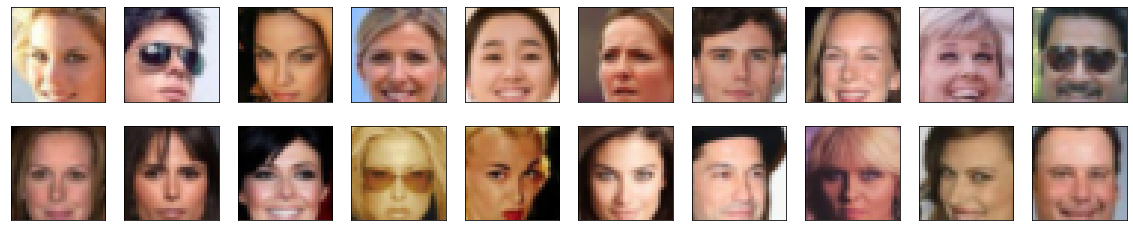

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min,max=feature_range
    x= x*(max-min)+min
    return x


In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.7961)
Max:  tensor(0.9922)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim=conv_dim
        self.conv1 = conv(3,conv_dim,4,batch_norm=False)# x, y = 64, depth 64
        self.conv2 = conv(conv_dim,conv_dim*2 ,4)# (32, 32, 128)
        self.conv3 = conv(conv_dim*2,conv_dim*4, 4)# (16, 16, 256)
        
        #self.conv4 = conv(conv_dim*4, conv_dim*8, 4) # (8, 8, 512)
        
        # Classification layer
        #self.conv5 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)
        
        self.fc = nn.Linear(conv_dim*4*4*4,1)
        self.dropout = nn.Dropout(0.5)
        
        
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        # relu applied to all conv layers but last
        out = F.leaky_relu(self.conv1(x),0.2)
        out = F.leaky_relu(self.conv2(out),0.2)
        out = F.leaky_relu(self.conv3(out),0.2)
        #out = F.relu(self.conv4(out))
        # last, classification layer
        #x = self.conv5(out)
        x = out.view(-1,self.conv_dim*4*4*4)
        x = self.fc(x)
        x= self.dropout(x)
   
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Helper function to create a transposed-convolutional layer, with optional batch normalization.
    """
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [12]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        self.dropout = nn.Dropout(0.5)
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x=  self.dropout(x)
        x = x.view(-1, self.conv_dim*4, 4, 4) 
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = self.t_conv3(x)
        x = F.tanh(x)
        
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


C:\Users\aleza\anaconda3\lib\site-packages\torch\nn\functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [13]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if classname in ['Linear', 'Conv']:
        m.weight.data.normal_(0, 0.02)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [15]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
  

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [17]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)*0.9
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [18]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
lr = 0.005
beta1=0.1
beta2=0.999
d_optimizer = optim.Adam(D.parameters(),lr,[beta1,beta2])
g_optimizer = optim.Adam(G.parameters(),lr,[beta1,beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [19]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            if train_on_gpu:
                real_images = real_images.cuda()
            d_loss = D(real_images)
            d_real_loss = real_loss(d_loss)
            #training with fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()

            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
        
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            # 2. Train the generator with an adversarial loss
            
            g_optimizer.zero_grad()
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
        
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) 
        
            g_loss.backward()
            g_optimizer.step()
            
             
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [20]:
# set number of epochs 
n_epochs = 30


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   30] | d_loss: 1.6992 | g_loss: 1.5270
Epoch [    1/   30] | d_loss: 0.8816 | g_loss: 0.6136
Epoch [    1/   30] | d_loss: 0.8510 | g_loss: 0.5248
Epoch [    1/   30] | d_loss: 0.9584 | g_loss: 0.6450
Epoch [    1/   30] | d_loss: 0.8889 | g_loss: 0.5622
Epoch [    1/   30] | d_loss: 0.8928 | g_loss: 0.5813
Epoch [    1/   30] | d_loss: 0.8392 | g_loss: 0.5641
Epoch [    1/   30] | d_loss: 0.8836 | g_loss: 0.5170
Epoch [    1/   30] | d_loss: 0.8453 | g_loss: 0.5288
Epoch [    1/   30] | d_loss: 0.9325 | g_loss: 0.5619
Epoch [    1/   30] | d_loss: 0.9400 | g_loss: 0.4936
Epoch [    1/   30] | d_loss: 0.8922 | g_loss: 0.5559
Epoch [    1/   30] | d_loss: 0.9054 | g_loss: 0.5074
Epoch [    1/   30] | d_loss: 0.9102 | g_loss: 0.5547
Epoch [    1/   30] | d_loss: 0.9097 | g_loss: 0.4761
Epoch [    1/   30] | d_loss: 0.8311 | g_loss: 0.5278
Epoch [    1/   30] | d_loss: 1.0149 | g_loss: 0.5724
Epoch [    1/   30] | d_loss: 0.8292 | g_loss: 0.5653
Epoch [    1/   30] | d_loss

Epoch [    3/   30] | d_loss: 0.8319 | g_loss: 0.5291
Epoch [    3/   30] | d_loss: 0.9670 | g_loss: 0.5359
Epoch [    3/   30] | d_loss: 0.8919 | g_loss: 0.5675
Epoch [    3/   30] | d_loss: 0.9848 | g_loss: 0.4807
Epoch [    3/   30] | d_loss: 0.8577 | g_loss: 0.5025
Epoch [    3/   30] | d_loss: 0.8750 | g_loss: 0.4995
Epoch [    3/   30] | d_loss: 0.8514 | g_loss: 0.5221
Epoch [    3/   30] | d_loss: 0.8945 | g_loss: 0.6174
Epoch [    3/   30] | d_loss: 0.8354 | g_loss: 0.5643
Epoch [    3/   30] | d_loss: 0.9586 | g_loss: 0.5603
Epoch [    3/   30] | d_loss: 0.8218 | g_loss: 0.5201
Epoch [    3/   30] | d_loss: 0.9225 | g_loss: 0.5532
Epoch [    3/   30] | d_loss: 0.9836 | g_loss: 0.5356
Epoch [    3/   30] | d_loss: 0.8486 | g_loss: 0.5447
Epoch [    3/   30] | d_loss: 0.7961 | g_loss: 0.5056
Epoch [    3/   30] | d_loss: 0.9408 | g_loss: 0.5198
Epoch [    3/   30] | d_loss: 0.7792 | g_loss: 0.5773
Epoch [    3/   30] | d_loss: 0.9894 | g_loss: 0.5523
Epoch [    3/   30] | d_loss

Epoch [    6/   30] | d_loss: 0.9642 | g_loss: 0.5318
Epoch [    6/   30] | d_loss: 0.8960 | g_loss: 0.4979
Epoch [    6/   30] | d_loss: 0.9507 | g_loss: 0.5404
Epoch [    6/   30] | d_loss: 0.8710 | g_loss: 0.5564
Epoch [    6/   30] | d_loss: 0.9453 | g_loss: 0.5431
Epoch [    6/   30] | d_loss: 0.8600 | g_loss: 0.5374
Epoch [    6/   30] | d_loss: 0.9457 | g_loss: 0.5201
Epoch [    6/   30] | d_loss: 0.9441 | g_loss: 0.4785
Epoch [    6/   30] | d_loss: 0.8452 | g_loss: 0.5631
Epoch [    6/   30] | d_loss: 0.8721 | g_loss: 0.5506
Epoch [    6/   30] | d_loss: 0.9295 | g_loss: 0.5594
Epoch [    6/   30] | d_loss: 0.8279 | g_loss: 0.5089
Epoch [    6/   30] | d_loss: 0.8357 | g_loss: 0.5215
Epoch [    6/   30] | d_loss: 0.8904 | g_loss: 0.5344
Epoch [    6/   30] | d_loss: 0.9546 | g_loss: 0.5156
Epoch [    6/   30] | d_loss: 0.8551 | g_loss: 0.5518
Epoch [    6/   30] | d_loss: 0.8800 | g_loss: 0.5584
Epoch [    6/   30] | d_loss: 0.8804 | g_loss: 0.5463
Epoch [    6/   30] | d_loss

Epoch [    9/   30] | d_loss: 0.7869 | g_loss: 0.5258
Epoch [    9/   30] | d_loss: 0.8756 | g_loss: 0.5048
Epoch [    9/   30] | d_loss: 0.8693 | g_loss: 0.5425
Epoch [    9/   30] | d_loss: 0.8624 | g_loss: 0.5839
Epoch [    9/   30] | d_loss: 0.8924 | g_loss: 0.5154
Epoch [    9/   30] | d_loss: 0.9333 | g_loss: 0.5095
Epoch [    9/   30] | d_loss: 0.7401 | g_loss: 0.5023
Epoch [    9/   30] | d_loss: 0.8972 | g_loss: 0.4945
Epoch [    9/   30] | d_loss: 0.7504 | g_loss: 0.5641
Epoch [    9/   30] | d_loss: 0.8856 | g_loss: 0.5599
Epoch [    9/   30] | d_loss: 0.8265 | g_loss: 0.5808
Epoch [    9/   30] | d_loss: 0.7500 | g_loss: 0.5844
Epoch [    9/   30] | d_loss: 0.8564 | g_loss: 0.5823
Epoch [    9/   30] | d_loss: 0.8838 | g_loss: 0.5067
Epoch [    9/   30] | d_loss: 0.8434 | g_loss: 0.5954
Epoch [    9/   30] | d_loss: 0.9703 | g_loss: 0.5920
Epoch [    9/   30] | d_loss: 0.9887 | g_loss: 0.5147
Epoch [    9/   30] | d_loss: 0.9390 | g_loss: 0.5432
Epoch [    9/   30] | d_loss

Epoch [   11/   30] | d_loss: 0.8916 | g_loss: 0.5202
Epoch [   11/   30] | d_loss: 0.9046 | g_loss: 0.5330
Epoch [   11/   30] | d_loss: 0.9190 | g_loss: 0.5685
Epoch [   11/   30] | d_loss: 0.7704 | g_loss: 0.5406
Epoch [   11/   30] | d_loss: 0.9351 | g_loss: 0.5897
Epoch [   11/   30] | d_loss: 0.9429 | g_loss: 0.6176
Epoch [   11/   30] | d_loss: 0.8064 | g_loss: 0.5015
Epoch [   11/   30] | d_loss: 0.8258 | g_loss: 0.5509
Epoch [   11/   30] | d_loss: 0.9266 | g_loss: 0.5305
Epoch [   11/   30] | d_loss: 0.9595 | g_loss: 0.5323
Epoch [   11/   30] | d_loss: 0.8863 | g_loss: 0.5600
Epoch [   11/   30] | d_loss: 0.7758 | g_loss: 0.5700
Epoch [   11/   30] | d_loss: 0.8608 | g_loss: 0.5312
Epoch [   11/   30] | d_loss: 0.9474 | g_loss: 0.4965
Epoch [   11/   30] | d_loss: 0.9278 | g_loss: 0.5545
Epoch [   11/   30] | d_loss: 0.9062 | g_loss: 0.5969
Epoch [   11/   30] | d_loss: 0.8933 | g_loss: 0.5513
Epoch [   11/   30] | d_loss: 0.9327 | g_loss: 0.5265
Epoch [   11/   30] | d_loss

Epoch [   14/   30] | d_loss: 0.8461 | g_loss: 0.5601
Epoch [   14/   30] | d_loss: 0.8086 | g_loss: 0.5565
Epoch [   14/   30] | d_loss: 0.9298 | g_loss: 0.5352
Epoch [   14/   30] | d_loss: 0.8651 | g_loss: 0.5249
Epoch [   14/   30] | d_loss: 0.8622 | g_loss: 0.5253
Epoch [   14/   30] | d_loss: 0.9623 | g_loss: 0.5734
Epoch [   14/   30] | d_loss: 0.8810 | g_loss: 0.5455
Epoch [   14/   30] | d_loss: 0.9498 | g_loss: 0.4999
Epoch [   14/   30] | d_loss: 0.8825 | g_loss: 0.5696
Epoch [   14/   30] | d_loss: 0.6825 | g_loss: 0.5152
Epoch [   14/   30] | d_loss: 0.8603 | g_loss: 0.5648
Epoch [   14/   30] | d_loss: 0.8649 | g_loss: 0.5687
Epoch [   14/   30] | d_loss: 0.8864 | g_loss: 0.5060
Epoch [   14/   30] | d_loss: 0.7281 | g_loss: 0.5390
Epoch [   14/   30] | d_loss: 0.8781 | g_loss: 0.5654
Epoch [   14/   30] | d_loss: 0.8482 | g_loss: 0.5662
Epoch [   14/   30] | d_loss: 0.7908 | g_loss: 0.5713
Epoch [   14/   30] | d_loss: 0.7364 | g_loss: 0.5296
Epoch [   14/   30] | d_loss

Epoch [   17/   30] | d_loss: 0.9177 | g_loss: 0.5269
Epoch [   17/   30] | d_loss: 0.8453 | g_loss: 0.5566
Epoch [   17/   30] | d_loss: 0.8400 | g_loss: 0.5633
Epoch [   17/   30] | d_loss: 0.8987 | g_loss: 0.5566
Epoch [   17/   30] | d_loss: 0.8434 | g_loss: 0.5515
Epoch [   17/   30] | d_loss: 0.8686 | g_loss: 0.5100
Epoch [   17/   30] | d_loss: 0.9556 | g_loss: 0.5350
Epoch [   17/   30] | d_loss: 0.8316 | g_loss: 0.5757
Epoch [   17/   30] | d_loss: 0.8446 | g_loss: 0.5723
Epoch [   17/   30] | d_loss: 0.8843 | g_loss: 0.5771
Epoch [   17/   30] | d_loss: 0.7963 | g_loss: 0.5137
Epoch [   17/   30] | d_loss: 0.7660 | g_loss: 0.5681
Epoch [   17/   30] | d_loss: 0.8349 | g_loss: 0.5489
Epoch [   17/   30] | d_loss: 0.7997 | g_loss: 0.5570
Epoch [   17/   30] | d_loss: 0.9070 | g_loss: 0.5161
Epoch [   17/   30] | d_loss: 0.9380 | g_loss: 0.6109
Epoch [   17/   30] | d_loss: 0.9139 | g_loss: 0.5652
Epoch [   17/   30] | d_loss: 0.9808 | g_loss: 0.5245
Epoch [   17/   30] | d_loss

Epoch [   19/   30] | d_loss: 0.9067 | g_loss: 0.5445
Epoch [   19/   30] | d_loss: 0.7819 | g_loss: 0.5834
Epoch [   19/   30] | d_loss: 0.8547 | g_loss: 0.5769
Epoch [   19/   30] | d_loss: 0.7812 | g_loss: 0.5834
Epoch [   19/   30] | d_loss: 0.9797 | g_loss: 0.5721
Epoch [   19/   30] | d_loss: 0.8612 | g_loss: 0.5085
Epoch [   19/   30] | d_loss: 0.8974 | g_loss: 0.5414
Epoch [   19/   30] | d_loss: 0.9192 | g_loss: 0.5368
Epoch [   19/   30] | d_loss: 0.8514 | g_loss: 0.5999
Epoch [   19/   30] | d_loss: 0.8437 | g_loss: 0.5760
Epoch [   19/   30] | d_loss: 0.8865 | g_loss: 0.5442
Epoch [   19/   30] | d_loss: 0.8856 | g_loss: 0.5389
Epoch [   19/   30] | d_loss: 0.9843 | g_loss: 0.5583
Epoch [   19/   30] | d_loss: 0.9093 | g_loss: 0.5781
Epoch [   19/   30] | d_loss: 0.9113 | g_loss: 0.5423
Epoch [   19/   30] | d_loss: 0.7912 | g_loss: 0.5994
Epoch [   19/   30] | d_loss: 0.8153 | g_loss: 0.5055
Epoch [   19/   30] | d_loss: 0.9205 | g_loss: 0.5760
Epoch [   19/   30] | d_loss

Epoch [   22/   30] | d_loss: 0.8737 | g_loss: 0.5545
Epoch [   22/   30] | d_loss: 0.7959 | g_loss: 0.5263
Epoch [   22/   30] | d_loss: 0.9547 | g_loss: 0.5703
Epoch [   22/   30] | d_loss: 1.0021 | g_loss: 0.5552
Epoch [   22/   30] | d_loss: 0.7943 | g_loss: 0.5449
Epoch [   22/   30] | d_loss: 0.8326 | g_loss: 0.5300
Epoch [   22/   30] | d_loss: 0.8651 | g_loss: 0.5500
Epoch [   22/   30] | d_loss: 0.8930 | g_loss: 0.5834
Epoch [   22/   30] | d_loss: 0.8691 | g_loss: 0.5353
Epoch [   22/   30] | d_loss: 0.8930 | g_loss: 0.5919
Epoch [   22/   30] | d_loss: 0.9177 | g_loss: 0.6001
Epoch [   22/   30] | d_loss: 0.8997 | g_loss: 0.6226
Epoch [   22/   30] | d_loss: 0.7609 | g_loss: 0.5338
Epoch [   22/   30] | d_loss: 0.9996 | g_loss: 0.5837
Epoch [   22/   30] | d_loss: 0.8566 | g_loss: 0.5897
Epoch [   22/   30] | d_loss: 0.9438 | g_loss: 0.5466
Epoch [   22/   30] | d_loss: 0.9506 | g_loss: 0.5718
Epoch [   22/   30] | d_loss: 0.7454 | g_loss: 0.5588
Epoch [   22/   30] | d_loss

Epoch [   25/   30] | d_loss: 0.6724 | g_loss: 0.5915
Epoch [   25/   30] | d_loss: 0.8942 | g_loss: 0.5687
Epoch [   25/   30] | d_loss: 0.8764 | g_loss: 0.6178
Epoch [   25/   30] | d_loss: 1.0370 | g_loss: 0.5710
Epoch [   25/   30] | d_loss: 0.8079 | g_loss: 0.5194
Epoch [   25/   30] | d_loss: 0.9295 | g_loss: 0.6294
Epoch [   25/   30] | d_loss: 0.8694 | g_loss: 0.5631
Epoch [   25/   30] | d_loss: 0.8827 | g_loss: 0.5863
Epoch [   25/   30] | d_loss: 0.8702 | g_loss: 0.5959
Epoch [   25/   30] | d_loss: 0.9306 | g_loss: 0.5599
Epoch [   25/   30] | d_loss: 0.9168 | g_loss: 0.5775
Epoch [   25/   30] | d_loss: 0.8177 | g_loss: 0.5662
Epoch [   25/   30] | d_loss: 0.8369 | g_loss: 0.6225
Epoch [   25/   30] | d_loss: 0.8166 | g_loss: 0.5823
Epoch [   25/   30] | d_loss: 0.7826 | g_loss: 0.6025
Epoch [   25/   30] | d_loss: 0.9611 | g_loss: 0.5931
Epoch [   25/   30] | d_loss: 0.7743 | g_loss: 0.5501
Epoch [   25/   30] | d_loss: 0.8664 | g_loss: 0.5878
Epoch [   25/   30] | d_loss

Epoch [   27/   30] | d_loss: 0.8895 | g_loss: 0.5550
Epoch [   27/   30] | d_loss: 0.9008 | g_loss: 0.5969
Epoch [   27/   30] | d_loss: 0.8963 | g_loss: 0.5852
Epoch [   27/   30] | d_loss: 0.8125 | g_loss: 0.6198
Epoch [   27/   30] | d_loss: 0.9241 | g_loss: 0.5833
Epoch [   27/   30] | d_loss: 0.8085 | g_loss: 0.5958
Epoch [   27/   30] | d_loss: 0.7995 | g_loss: 0.5733
Epoch [   27/   30] | d_loss: 0.8279 | g_loss: 0.6045
Epoch [   27/   30] | d_loss: 0.9730 | g_loss: 0.5849
Epoch [   27/   30] | d_loss: 0.8365 | g_loss: 0.5590
Epoch [   27/   30] | d_loss: 0.8945 | g_loss: 0.5825
Epoch [   27/   30] | d_loss: 0.9405 | g_loss: 0.5575
Epoch [   27/   30] | d_loss: 0.8828 | g_loss: 0.5242
Epoch [   27/   30] | d_loss: 0.9200 | g_loss: 0.5402
Epoch [   27/   30] | d_loss: 0.9220 | g_loss: 0.5345
Epoch [   27/   30] | d_loss: 0.9292 | g_loss: 0.5648
Epoch [   27/   30] | d_loss: 0.8592 | g_loss: 0.5232
Epoch [   27/   30] | d_loss: 0.7982 | g_loss: 0.6387
Epoch [   27/   30] | d_loss

Epoch [   30/   30] | d_loss: 0.8123 | g_loss: 0.6125
Epoch [   30/   30] | d_loss: 0.8919 | g_loss: 0.6518
Epoch [   30/   30] | d_loss: 0.8398 | g_loss: 0.6636
Epoch [   30/   30] | d_loss: 0.8917 | g_loss: 0.6558
Epoch [   30/   30] | d_loss: 0.9398 | g_loss: 0.6540
Epoch [   30/   30] | d_loss: 0.9661 | g_loss: 0.6633
Epoch [   30/   30] | d_loss: 0.8067 | g_loss: 0.6718
Epoch [   30/   30] | d_loss: 0.8361 | g_loss: 0.6791
Epoch [   30/   30] | d_loss: 0.9155 | g_loss: 0.6346
Epoch [   30/   30] | d_loss: 0.8265 | g_loss: 0.6921
Epoch [   30/   30] | d_loss: 0.8489 | g_loss: 0.6549
Epoch [   30/   30] | d_loss: 0.7915 | g_loss: 0.6375
Epoch [   30/   30] | d_loss: 0.9707 | g_loss: 0.6253
Epoch [   30/   30] | d_loss: 0.9496 | g_loss: 0.6296
Epoch [   30/   30] | d_loss: 0.9039 | g_loss: 0.6869
Epoch [   30/   30] | d_loss: 0.8003 | g_loss: 0.6854
Epoch [   30/   30] | d_loss: 0.9223 | g_loss: 0.6579
Epoch [   30/   30] | d_loss: 0.7144 | g_loss: 0.6792
Epoch [   30/   30] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

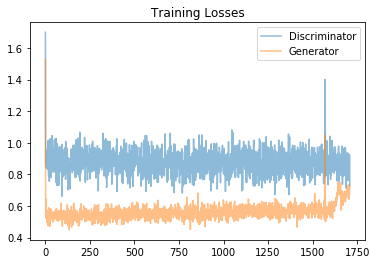

In [21]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [22]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [23]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

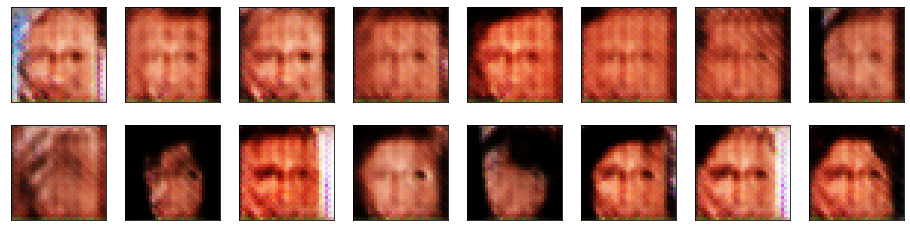

In [24]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)
* A biased dataset can give help te model to learn well
* Increase of the size of z will help the model learn faster
* A large model will learn more features and train longer.
* The genrtor is not able to generate well different faces
* Using  different opitmizers: SGD for the discrimitor and Adam for the genrator
* To get a better output we can add noice to the input of the generator and provide some noice to in the generator
* Train for more epochs


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.